<a href="https://colab.research.google.com/github/joachimboyden/Advent-of-code/blob/main/ydf_working_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![HolyChurninityLogo](https://github.com/jaunceymyles/The-Holy-Churnity-Father-Son-and-Departed-User-/blob/main/Trinity-overlay-overlay-overlay.jpg?raw=1)

![HolyChurninityLogo2](https://github.com/jaunceymyles/The-Holy-Churnity-Father-Son-and-Departed-User-/blob/main/ProfLOGO.png?raw=1)

# Swan Teleco _Churn Prediction and Risk Management_

### Summary

The aims of this project are find key predictors in _Swan Teleco's_ customer churn to implement business decisions for the Customer Retention Marketing team.

Our objective aims are to:
- Find customers most at risk to churning
- Identify key data points that indicate a customers risk of churning, deducing factors to incentivise
- Quantify the churn risk for all remaining customers

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [8]:
raw_data = pd.read_excel('1 - Project Data.xlsx')

In [9]:
raw_data.head()

CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender Senior Citizen  \
0  33.964131, -118.272783  33.964131 -118.272783    Male             No   
1   34.059281, -118.30742  34.059281 -118.307420  Female             No   
2  34.048013, -118.293953  34.048013 -118.293953  Female             No   
3  34.062125, -118.315709  34.062125 -118.315709  Female             No   
4  34.039224, -118.266293  34.039224 -118.266293    Male             No   

  Partner Dependents  Tenure Months Phone Service Multiple Lines  \
0      No         No              2           Yes             No   
1      No        Yes              2           Yes             No   
2      No        Yes              8           Yes            Yes   
3     Yes        Yes             28           Yes            Yes   
4      No        Yes             49           Yes            Yes   

  Internet Service Online Security Online Backup Device Protection  \
0              DSL             Yes           Yes                No   
1      Fiber optic              No            No                No   
2      Fiber optic              No            No               Yes   
3      Fiber optic              No            No               Yes   
4      Fiber optic              No           Yes               Yes   

  Tech Support Streaming TV Streaming Movies        Contract  \
0           No           No               No  Month-to-month   
1           No           No               No  Month-to-month   
2           No          Yes              Yes  Month-to-month   
3          Yes          Yes              Yes  Month-to-month   
4           No          Yes              Yes  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Total Charges  \
0               Yes               Mailed check            53.85        108.15   
1               Yes           Electronic check            70.70        151.65   
2               Yes           Electronic check            99.65         820.5   
3               Yes           Electronic check           104.80       3046.05   
4               Yes  Bank transfer (automatic)           103.70        5036.3   

  Churn Label  Churn Value                   Churn Reason  
0         Yes            1   Competitor made better offer  
1         Yes            1                          Moved  
2         Yes            1                          Moved  
3         Yes            1                          Moved  
4         Yes            1  Competitor had better devices

#### Cleaning Data

In [10]:
def TotalChargesEst(df):
    '''
    This function estimate the total charges from missing data.
    We thought about adding a randomised error utilising the difference in modelled data to real data, however for only filling 11 values, we don't see a significant difference being made.
    Further to this the distribution of errors in our model and real values was somewhat geometric about 0 errors so on average we wouldn't expect this to make a difference.
    '''
    df['total_charges'] = pd.to_numeric(df['total_charges'].replace(' ', np.nan), errors='coerce')

    changed_indices = df[df['total_charges'].isna()].index

    calculated_total = df['monthly_charges']*df['tenure_months']
    df['total_charges'] = df['total_charges'].fillna(calculated_total)

    return df, changed_indices

In [11]:
def BoolMapping(df, cols):
    '''
    This function maps all columns in cols to a boolean data type.
    Noteably, 'Churn Value' is not transferred to boolean for ease after modelling.
    '''

    for col in cols:
        if col in ['senior_citizen', 'partner', 'dependents', 'phone_service', 'paperless_billing']:
            df[col] = df[col].map({'Yes': 1, 'No': 0})
        if col == 'gender':
            df['is_male'] = df[col].map({'Male': 1, 'Female': 0})
            df.drop(columns = 'gender', inplace=True)
            cols = ['is_male' if c == 'gender' else c for c in cols]
    return df, cols

In [12]:
def Cleaning(rawdf, catcol, boolcol, stringcol, floatcol,
             dropcol):
    '''
    This function aims to clean all data as apart of the data pipeline, to prepare for modelling.
    Key points this function targets:
    -Normalising Column names
    -Fill any missing Data
    -Change types of columns
    -Drop any columns
    -Return a numeric and bool dataframe
    '''

    df = rawdf.copy()

    #Change Column Names
    df.columns = df.columns.str.strip().str.replace(' ',  '_').str.lower()

    #FillMissingData Section
    df, est_indicies = TotalChargesEst(df)
    df['churn_reason'].fillna('No Reason', inplace=True)

    #ChangeType Section

    df[catcol] = df[catcol].astype('category')
    #Bools
    #df, boolcol_altered = BoolMapping(df, cols = boolcol)
    #df[boolcol_altered] = df[boolcol_altered].astype('bool')
    df[stringcol] = df[stringcol].astype('string')
    df[floatcol] = df[floatcol].astype('float')

    #DropColumns
    df.drop(columns=dropcol, inplace=True)

    #Return numeric focues dataframe for visualing
    dfnumeric = df.copy()
    #dfnumeric[boolcol_altered] = df[boolcol_altered].astype('int')

    return df#, dfnumeric

In [13]:
#Columns of which datatype needed to be changed
CatCol = ['city', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'contract', 'paperless_billing', 'payment_method', 'churn_reason']
BoolCol = ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'churn_value', 'paperless_billing']
StringCol = ['customerid']
FloatCol = ['total_charges']
DropCol = ['country', 'count', 'churn_label', 'lat_long', 'state', 'churn_reason', 'city', 'latitude', 'longitude']

In [14]:
cleandf = Cleaning(raw_data, catcol=CatCol, boolcol=BoolCol, stringcol=StringCol, floatcol=FloatCol, dropcol=DropCol)

/tmp/ipython-input-10-2053115791.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['total_charges'] = pd.to_numeric(df['total_charges'].replace(' ', np.nan), errors='coerce')
/tmp/ipython-input-12-1178956965.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['churn_reason'].fillna('No Reas

In [15]:
cleandf.head()

customerid  zip_code  gender senior_citizen partner dependents  \
0  3668-QPYBK     90003    Male             No      No         No   
1  9237-HQITU     90005  Female             No      No        Yes   
2  9305-CDSKC     90006  Female             No      No        Yes   
3  7892-POOKP     90010  Female             No     Yes        Yes   
4  0280-XJGEX     90015    Male             No      No        Yes   

   tenure_months phone_service multiple_lines internet_service  \
0              2           Yes             No              DSL   
1              2           Yes             No      Fiber optic   
2              8           Yes            Yes      Fiber optic   
3             28           Yes            Yes      Fiber optic   
4             49           Yes            Yes      Fiber optic   

  online_security online_backup device_protection tech_support streaming_tv  \
0             Yes           Yes                No           No           No   
1              No            No                No           No           No   
2              No            No               Yes           No          Yes   
3              No            No               Yes          Yes          Yes   
4              No           Yes               Yes           No          Yes   

  streaming_movies        contract paperless_billing  \
0               No  Month-to-month               Yes   
1               No  Month-to-month               Yes   
2              Yes  Month-to-month               Yes   
3              Yes  Month-to-month               Yes   
4              Yes  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges  churn_value  
0               Mailed check            53.85         108.15            1  
1           Electronic check            70.70         151.65            1  
2           Electronic check            99.65         820.50            1  
3           Electronic check           104.80        3046.05            1  
4  Bank transfer (automatic)           103.70        5036.30            1

#### Feature Engineering

In [16]:
def bucketise_feature(df :pd.DataFrame, feature :str, bins :list) -> pd.DataFrame:
    df = df.copy()
    labels = [i for i in range(1, len(bins))]
    df[f'{feature}_bucketed'] = pd.cut(df[feature], bins, labels=labels)
    return df

In [17]:
# LABEL ENCODING FUNCTION
# Map unique categorical values to numeric

def label_encode(df, internet_cols):
    # Loop over features with the same column values
    for i in internet_cols:
        df[f'{i}_encoded'] = df[i].map({'No internet service':0, 'No':1, 'Yes':2})

    # Label encoding for specific features
    df['multiple_lines_encoded'] = df['multiple_lines'].map({'No phone service':0, 'No':1, 'Yes':2})
    df['internet_service_encoded'] = df['internet_service'].map({'No':0, 'DSL':1, 'Fiber optic':2})
    df['contract_encoded'] = df['contract'].map({'Month-to-month':0, 'Two year':2, 'One year':1})
    df['payment_method_encoded'] = df['payment_method'].map({'Mailed check':0, 'Electronic check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3})
    #df['encoded_churn_reason'] = df['churn_reason'].map({'Competitor made better offer':1, 'Moved':2, 'Competitor had better devices':3,'Competitor offered higher download speeds':4, 'Competitor offered more data':4, 'Price too high':5, 'Product dissatisfaction':6, 'Service dissatisfaction':7, 'Lack of self-service on Website':8, 'Network reliability':9, 'Limited range of services':10, 'Lack of affordable download/upload speed':11, 'Long distance charges':12, 'Extra data charges':13, "Don't know":14, 'Poor expertise of online support':15, 'Poor expertise of phone support':16, 'Attitude of service provider':17, 'Attitude of support person':18, 'Deceased':19, 'No reason':20})

    # Drop original columns
    df.drop(internet_cols, axis = 1, inplace = True)
    df.drop(['multiple_lines', 'internet_service', 'contract', 'payment_method'], axis = 1, inplace = True)

    return df

In [18]:
def feature_eng(input_df):
    df = input_df.copy()

    # Bucketising
    df = bucketise_feature(df, 'total_charges', [x for x in range(0, 9000, 500)])
    df = bucketise_feature(df, 'monthly_charges', [x for x in range(0, 130, 20)])
    df.drop(['monthly_charges', 'total_charges'], axis=1, inplace=True)

    # Setting id as index
    df.set_index('customerid', inplace=True)

    # Truncate ZipCode
    df['truncated_zip'] = df['zip_code'].astype(str).str[:3].astype(int)
    df.drop(['zip_code'], axis = 1, inplace = True)

    # Label Encoding

    # List of features with identical values for mapping
    #internet_cols = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
    #df = label_encode(df, internet_cols)

    # Keep certain columns
    #df = df[['internet_service_encoded', 'tenure_months', 'payment_method_encoded', 'dependents', 'total_charges_bucketed', 'contract_encoded', 'churn_value']]

    Xdata = df.drop(columns = 'churn_value')
    ydata = df['churn_value']

    return Xdata, ydata

#### Random Forest Regressor

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
#Maybe use RandomizedSearchCV instead?
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
X, y = feature_eng(cleandf)

X_train_fe, X_test_fe, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [22]:
X_train_fe.head()

gender senior_citizen partner dependents  tenure_months  \
customerid                                                            
4950-BDEUX    Male             No      No         No             35   
7993-NQLJE    Male             No     Yes        Yes             15   
7321-ZNSLA    Male             No     Yes        Yes             13   
4922-CVPDX  Female             No     Yes         No             26   
2903-YYTBW    Male             No     Yes        Yes              1   

           phone_service    multiple_lines internet_service online_security  \
customerid                                                                    
4950-BDEUX            No  No phone service              DSL              No   
7993-NQLJE           Yes                No      Fiber optic             Yes   
7321-ZNSLA            No  No phone service              DSL             Yes   
4922-CVPDX           Yes                No              DSL              No   
2903-YYTBW           Yes                No              DSL              No   

           online_backup device_protection tech_support streaming_tv  \
customerid                                                             
4950-BDEUX            No               Yes           No          Yes   
7993-NQLJE            No                No           No           No   
7321-ZNSLA           Yes                No          Yes           No   
4922-CVPDX           Yes               Yes           No          Yes   
2903-YYTBW            No                No           No           No   

           streaming_movies        contract paperless_billing  \
customerid                                                      
4950-BDEUX              Yes  Month-to-month                No   
7993-NQLJE               No  Month-to-month                No   
7321-ZNSLA               No        Two year                No   
4922-CVPDX              Yes        Two year               Yes   
2903-YYTBW               No  Month-to-month                No   

                     payment_method total_charges_bucketed  \
customerid                                                   
4950-BDEUX         Electronic check                      4   
7993-NQLJE             Mailed check                      3   
7321-ZNSLA             Mailed check                      2   
4922-CVPDX  Credit card (automatic)                      4   
2903-YYTBW         Electronic check                      1   

           monthly_charges_bucketed  truncated_zip  
customerid                                          
4950-BDEUX                        3            923  
7993-NQLJE                        4            959  
7321-ZNSLA                        3            960  
4922-CVPDX                        4            926  
2903-YYTBW                        3            925

#### YDF Modelling (Finding Optimal HyperParameters)

In [ ]:
!pip install ydf

In [23]:
import ydf

In [24]:
ydfmodel = ydf.RandomForestLearner(label='churn_value', max_depth=5, winner_take_all=False)

X_train_fe_ydf = X_train_fe.copy()
X_test_fe_ydf = X_test_fe.copy()

X_train_fe_ydf['churn_value'] = y_train
X_test_fe_ydf['churn_value'] = y_test


ydfmodeltrained = ydfmodel.train(X_train_fe_ydf)

Train model on 5634 examples
Model trained in 0:00:00.501470


In [25]:
ydfmodeltrained.evaluate(X_train_fe_ydf)

Evaluation()

In [26]:
ydfmodeltrained.evaluate(X_test_fe_ydf)

Evaluation()

In [27]:
ydfmodeltrained.plot_tree()

In [28]:
ydfmodeltrained.describe()

In [29]:
tuner = ydf.RandomSearchTuner(num_trials=50)

In [30]:
new_model = ydf.GradientBoostedTreesLearner(tuner=tuner, label='churn_value').train(X_train_fe_ydf)

Train model on 5634 examples
Model trained in 0:00:00.940946


In [31]:
new_model.evaluate(X_train_fe_ydf)

Evaluation()

In [32]:
new_model.evaluate(X_test_fe_ydf)

Evaluation()

In [33]:
new_model.plot_tree()

In [34]:
new_model.describe()

In [35]:
# Use model to predict on train set
# Use model to predict on train set
X_results = X.copy()
X_results['y_pred'] = ydfmodeltrained.predict(X)
X_results['y_real'] = y

X_results.head()
#X_results['y_prob'] = ydfmodeltrained.predict(X, predict_proba = True)

gender senior_citizen partner dependents  tenure_months  \
customerid                                                            
3668-QPYBK    Male             No      No         No              2   
9237-HQITU  Female             No      No        Yes              2   
9305-CDSKC  Female             No      No        Yes              8   
7892-POOKP  Female             No     Yes        Yes             28   
0280-XJGEX    Male             No      No        Yes             49   

           phone_service multiple_lines internet_service online_security  \
customerid                                                                 
3668-QPYBK           Yes             No              DSL             Yes   
9237-HQITU           Yes             No      Fiber optic              No   
9305-CDSKC           Yes            Yes      Fiber optic              No   
7892-POOKP           Yes            Yes      Fiber optic              No   
0280-XJGEX           Yes            Yes      Fiber optic              No   

           online_backup device_protection tech_support streaming_tv  \
customerid                                                             
3668-QPYBK           Yes                No           No           No   
9237-HQITU            No                No           No           No   
9305-CDSKC            No               Yes           No          Yes   
7892-POOKP            No               Yes          Yes          Yes   
0280-XJGEX           Yes               Yes           No          Yes   

           streaming_movies        contract paperless_billing  \
customerid                                                      
3668-QPYBK               No  Month-to-month               Yes   
9237-HQITU               No  Month-to-month               Yes   
9305-CDSKC              Yes  Month-to-month               Yes   
7892-POOKP              Yes  Month-to-month               Yes   
0280-XJGEX              Yes  Month-to-month               Yes   

                       payment_method total_charges_bucketed  \
customerid                                                     
3668-QPYBK               Mailed check                      1   
9237-HQITU           Electronic check                      1   
9305-CDSKC           Electronic check                      2   
7892-POOKP           Electronic check                      7   
0280-XJGEX  Bank transfer (automatic)                     11   

           monthly_charges_bucketed  truncated_zip    y_pred  y_real  
customerid                                                            
3668-QPYBK                        3            900  0.361052       1  
9237-HQITU                        4            900  0.523034       1  
9305-CDSKC                        5            900  0.480672       1  
7892-POOKP                        6            900  0.242966       1  
0280-XJGEX                        6            900  0.255622       1

In [36]:
top_500 = X_results.loc[X_results['y_real'] == 0].sort_values(by=['y_pred'], ascending = False).iloc[0:500, :][['y_pred', 'y_real']]
remaining = X_results.drop(top_500.index)[['y_pred', 'y_real']]

In [37]:
remaining.head()

y_pred  y_real
customerid                  
3668-QPYBK  0.361052       1
9237-HQITU  0.523034       1
9305-CDSKC  0.480672       1
7892-POOKP  0.242966       1
0280-XJGEX  0.255622       1

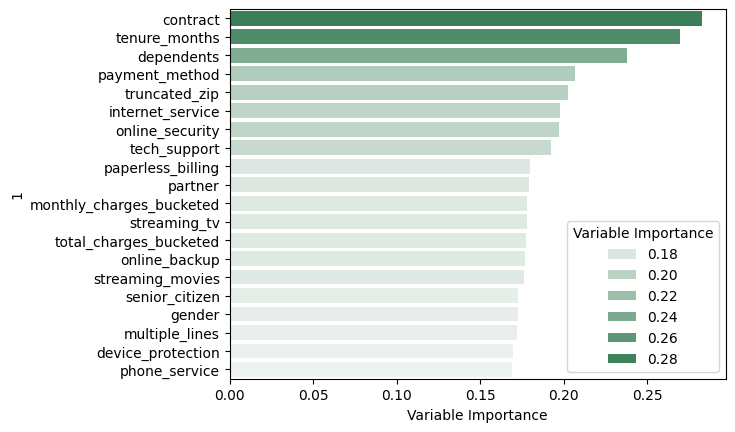

In [72]:
fig = sns.barplot(data=pd.DataFrame(new_model.variable_importances()['INV_MEAN_MIN_DEPTH']).sort_values(by=0, ascending=False), x=0, y=1, hue=0, palette=sns.light_palette("seagreen", as_cmap=True))
#plt.x_label('Variable Importance')
fig.legend(title='Variable Importance')
plt.xlabel('Variable Importance')
plt.savefig('Variable_importance.png')